#프로젝트2: Vocabulary Size를 변경해서 시도해보기

노드 5에서는 모델을 변경하고, 모델을 조합해서 성능을 올렸다.

하지만 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않는다.

데이터의 전처리는 모델의 성능에 직접적인 영향을 준다.

특히 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라 성능에 영향을 준다.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하된다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해보자.


In [58]:
import tensorflow
import matplotlib
import seaborn
import numpy
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.12.0
3.7.1
0.12.2
1.23.5
1.5.3
1.2.2


In [59]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [60]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#1.모든 단어 사용

##1)데이터 확인하기

In [62]:
#train data와 test data로 나누어 변수에 각각 저장.

(x_train, y_train), (x_test, y_test) = reuters.load_data(test_split=0.2)
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


##2)데이터 복원하기

In [63]:
#'reuters'데이터셋의 단어와 단어의 인덱스를 매핑한 딕셔너리인 'word_index'를 로드
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [64]:
#'index_word'로 바꾸기
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줌
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): #주어진 토큰들을 순회
  index_to_word[index]=token  #'index_to_word'딕셔너리에 각 인덱스를 key로, 해당 토큰을 value로 저장

In [65]:
#전체 훈련용 뉴스 데이터(x_train)를 텍스트 데이터로 변환
decoded = []
for j in range(len(x_train)):
    k = ' '.join([index_to_word[index] for index in x_train[j]])
    decoded.append(k)

x_train = decoded
print(len(x_train))

8982


In [66]:
#전체 테스트용 뉴스 데이터(x_test)를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [67]:
#잘 변환 되었는지 각각 5개씩 출력
x_train[:5]

x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arsenio yulo said yu

모든 단어를 사용하니 unk는 없다.

##3)벡터화하기

In [68]:
#DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개가 된다.

모든 단어를 사용했기 때문에 DTM의 열의 개수도 26,506개로, num_words=10,000로 지정했을때보다 크다.

In [69]:
#TF-IDF 생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


##4)나이브 베이즈 분류기 모델


In [70]:
#다항분포 나이브 베이즈 모델 학습
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [71]:
#test data 전처리 for 정확도 측정
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

#테스트 데이터에 대한 예측
predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


오히려 모든 단어를 사용하니 정확도는 약 5% 떨어졌다.

##5)성능평가 지표

In [72]:
#precision, recall, f1-score의 성능지표 ('classification_report()'함수)
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
          17       0.00    

정확도도 6%가량 떨어졌다.

##6)다양한 머신러닝 모델: CNB, 로지스틱 회귀, 랜덤 포레스트

In [73]:
#CNB(컴플리먼트 나이브 베이즈) 모델 학습
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [74]:
#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


다중 나이브 베이즈 모델보다 약 16% 가량 높은 성능을 보인다.

---



In [75]:
#선형회귀 모델 학습
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
  #'C': 정규화이 강도를 결정, 값이 작을수록 강한 정규화가 적용
  #'penalty': 정규화의 유형을 지정. l2는 L2정규화를 의미
  #'max_iter':최적화 과정에서의 최대 반복 횟수를 지정

lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [76]:
#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test)  #테스트 데이터에 대한 예측
print('정확도:', accuracy_score(y_test, predicted))  #예측값과 실제값 비교

정확도: 0.8161175422974176


다중 나이브 베이즈 모델보다 약 18% 이상 높은 성능을 보인다.


---
DTM이나 TF-IDF행렬의 경우 고차원이면서 대부분의 값이 0인 희소한 데이터이므로 트리 계열의 모델에서 성능이 나오지 않는다.

그렇지만 하나 정도 랜덤 포레스트 모델로 진행해보고자 한다.


In [77]:
#랜덤 포레스트 학습
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [78]:
#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


다중 나이브 베이즈: 0.59

컴플리먼트 나이브 베이즈: 0.76

로지스틱 회귀: 0.81

랜덤 포레스트: 0.65

#2.빈도수 상위 5,000개의 단어만 사용

##1)데이터 확인하기

In [79]:
#train data와 test data로 나누어 변수에 각각 저장.

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


##2)데이터 복원하기

In [80]:
#'reuters'데이터셋의 단어와 단어의 인덱스를 매핑한 딕셔너리인 'word_index'를 로드
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [81]:
#'index_word'로 바꾸기
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줌
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): #주어진 토큰들을 순회
  index_to_word[index]=token  #'index_to_word'딕셔너리에 각 인덱스를 key로, 해당 토큰을 value로 저장

In [82]:
#전체 훈련용 뉴스 데이터(x_train)를 텍스트 데이터로 변환
decoded = []
for j in range(len(x_train)):
    k = ' '.join([index_to_word[index] for index in x_train[j]])
    decoded.append(k)

x_train = decoded
print(len(x_train))

8982


In [83]:
#전체 테스트용 뉴스 데이터(x_test)를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [84]:
#잘 변환 되었는지 각각 5개씩 출력
x_train[:5]

x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey during the curr

##3)벡터화하기

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [86]:
#DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개가 된다.

그런데, 앞서 데이터 로드할때, num_words=5000이라는 값을 사용했음에도 DTM의 열의 개수는 4867개이다.

그 이유는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰을 제거하기 때문이다.

In [87]:
#TF-IDF 생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


##4)나이브 베이즈 분류기 모델


In [88]:
#다항분포 나이브 베이즈 모델 학습
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [89]:
#test data 전처리 for 정확도 측정
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

#테스트 데이터에 대한 예측
predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


nums_word를 10,000에서 5,000으로 감소시키니 정확도가 약 2% 올랐다.

##5)성능평가 지표

In [90]:
#precision, recall, f1-score의 성능지표 ('classification_report()'함수)
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

    macro: 단순 평균
    weighted: 각 클래스에 속하는 표본의 개수로 가중 평균
    accuracy:정확도. 전체 학습 데이터의 개수에서 클래스를 정확히 맞춘 개수의 비율

##6)다양한 머신러닝 모델: CNB, 로지스틱 회귀, 랜덤 포레스트

In [91]:
#CNB(컴플리먼트 나이브 베이즈) 모델 학습
cb = ComplementNB()
cb.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


다중 나이브 베이즈 모델보다 ~% 이상 높은 성능을 보인다.

---



In [92]:
#선형회귀 모델 학습
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8032056990204809




---



In [93]:
#랜덤 포레스트 학습
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


다중 나이브 베이즈: 0.67

컴플리먼트 나이브 베이즈: 0.77

로지스틱 회귀: 0.80

랜덤 포레스트: 0.70

#3.직접 단어 개수를 설정해서 사용

변화된 단어 수에 따른 모델의 성능을 연구해보기.

최소 3가지 경우 이상 (나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅)

모든 단어를 사용하면 정확도가 떨어지고, num_words=5,000개로 줄여서 사용하면 정확도가 올라갔다.

따라서, num_words=2,500개로 지정해서 진행해보겠다.

##1)num_words=2500개로 지정

In [94]:
#train data와 test data로 나누어 변수에 각각 저장.

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=2500, test_split=0.2)
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [95]:
#전체 훈련용 뉴스 데이터(x_train)를 텍스트 데이터로 변환
decoded = []
for j in range(len(x_train)):
    k = ' '.join([index_to_word[index] for index in x_train[j]])
    decoded.append(k)

x_train = decoded
print(len(x_train))

8982


In [96]:
#전체 테스트용 뉴스 데이터(x_test)를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [97]:
#잘 변환 되었는지 각각 5개씩 출력
x_train[:5]

x_test[:5]

['<sos> the great atlantic and pacific <unk> co said its three year <unk> mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations <unk> 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> <unk> sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey during the curren

In [98]:
#DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 2430)


num_words=2500으로 했기 때문에, DTM행렬의 열도 2500개보다 적은 2430개이다.

In [99]:
#TF-IDF 생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 2430)


In [100]:
#다항분포 나이브 베이즈 모델 학습
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [101]:
#test data 전처리 for 정확도 측정
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

#테스트 데이터에 대한 예측
predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6905609973285841


num_words=5000일때보다 약 2%가량 올라 69%가 되었다.

##2)다양한 머신러닝 모델: CNB, 로지스틱 회귀, 랜덤 포레스트


In [102]:
#CNB(컴플리먼트 나이브 베이즈) 모델 학습
cb = ComplementNB()
cb.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7609082813891362




---



In [103]:
#선형회귀 모델 학습
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7831700801424755




---



In [104]:
#랜덤 포레스트 학습
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.705253784505788


다중 나이브 베이즈: 0.69

컴플리먼트 나이브 베이즈: 0.76

로지스틱 회귀: 0.78

랜덤 포레스트: 0.70

#4.딥러닝 모델과 비교해보기

RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 학습 (단, Word2Vec 등의 pretrained model은 사용X)

In [115]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [105]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
print(len(x_train), len(x_test))

8982 2246


합쳐진 데이터의 shape: (11228,)
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.96419665122906


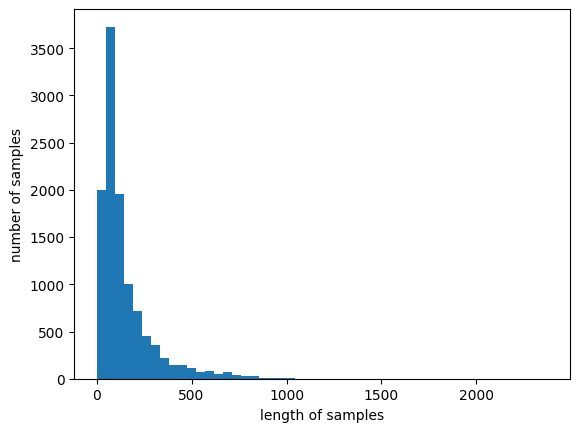

In [107]:
#데이터(뉴스 길이, x_test + x_train) 확인
x_data = np.concatenate((x_train, x_test), axis=0)
max_len = max(len(l) for l in x_data)

#수치화
print("합쳐진 데이터의 shape:", x_data.shape)
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_data)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_data))/len(x_data)))

#시각화
plt.hist([len(s) for s in x_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [109]:
x_train = pad_sequences(x_train, maxlen=1500)
x_test = pad_sequences(x_test, maxlen=1500)

In [ ]:
vocab_size = len(index_to_word)
word_vector_dim = 128

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim))
model.add(LSTM(128))
model.add(Dense(46, activation='softmax'))

mc = ModelCheckpoint("reuters.h5", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/100
113/113 [==============================] - 593s 5s/step - loss: 2.4201 - accuracy: 0.3883 - val_loss: 2.0045 - val_accuracy: 0.4825
Epoch 2/100
 17/113 [===>..........................] - ETA: 7:25 - loss: 1.9510 - accuracy: 0.4779